In [1]:
#BFのヒストリカルデータ
#一括でOHLCV取得

from datetime import datetime
import calendar, ccxt, time
import pandas as pd
import numpy as np


# 現在時刻のUTC naiveオブジェクト
now = datetime.utcnow()

# UTC naiveオブジェクト -> UnixTime
unixtime = calendar.timegm(now.utctimetuple())

#APIキーが必要
bybit_f = ccxt.bybit({'apiKey': ,
                      'secret': ,})




ohlcvs = []

#1000本分の１分足取得（1万本欲しいなら「２」を「１０１」に）
for i in range(1, 1500):
  since = (unixtime - 1000 * 60 * i) * 1000
  ohlcv = bybit_f.fetch_ohlcv(symbol='BTC/USDT:USDT', timeframe='1m', since=since, limit=1000)
  ohlcvs[0:0] = ohlcv



#タイムスタンプをdatetimeに変換
for i in range(0, len(ohlcvs)):
  ohlcvs[i][0] = datetime.fromtimestamp(ohlcvs[i][0]/1000)

/var/folders/hr/9fhcvhg11vj7h2_0pwl9jxd40000gn/T/ipykernel_1883/1891782994.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


In [2]:
#DataFrameに変換
df = pd.DataFrame(ohlcvs)
df.columns = ['Time',"Open", "High", "Low", "Close", 'Volume']
df.set_index('Time', inplace=True)

#重複削除、欠損値補完
df = df[~df.duplicated()]
df = df.asfreq('T', method='ffill')
df = df.reset_index()
print(df)

                       Time      Open      High       Low     Close   Volume
0       2022-07-17 14:11:00   21299.5   21310.0   21299.5   21303.0   39.020
1       2022-07-17 14:12:00   21303.0   21328.5   21302.5   21315.0   90.784
2       2022-07-17 14:13:00   21315.0   21347.0   21310.0   21337.5  158.869
3       2022-07-17 14:14:00   21337.5   21356.5   21330.5   21340.5   86.634
4       2022-07-17 14:15:00   21340.5   21340.5   21336.0   21336.0   38.586
...                     ...       ...       ...       ...       ...      ...
1498995 2025-05-23 13:26:00  110680.5  110732.2  110680.4  110732.2   35.120
1498996 2025-05-23 13:27:00  110732.2  110737.9  110704.0  110710.9   18.570
1498997 2025-05-23 13:28:00  110710.9  110769.2  110710.9  110769.2   24.785
1498998 2025-05-23 13:29:00  110769.2  110800.0  110761.1  110761.1   28.000
1498999 2025-05-23 13:30:00  110761.1  110802.5  110761.1  110770.1   23.938

[1499000 rows x 6 columns]


/var/folders/hr/9fhcvhg11vj7h2_0pwl9jxd40000gn/T/ipykernel_1883/834649359.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T', method='ffill')


In [3]:
#特徴量エンジニアリング
df_feature = [[]]





df_feature = pd.DataFrame(index=range(len(df)),columns=["SMA5/current", "SMA30/current"])

df_feature['1min_ret'] = (df["Close"] - df["Open"]) / df["Open"]
df_feature['1min_ret_1min_ago'] = df_feature['1min_ret'].shift(1)


df["5分前Close"] = df["Close"].shift(5)
df_feature['5min_ret'] = (df["Close"] - df["5分前Close"]) / df["5分前Close"]

df["10分前Close"] = df["Close"].shift(10)
df_feature['10min_ret'] = (df["Close"] - df["10分前Close"]) / df["10分前Close"]

df["15分前Close"] = df["Close"].shift(15)
df_feature['15min_ret'] = (df["Close"] - df["15分前Close"]) / df["15分前Close"]

df["60分前Close"] = df["Close"].shift(60)
df_feature['60min_ret'] = (df["Close"] - df["60分前Close"]) / df["60分前Close"]


df_feature['1min_ret_HL'] = (df["High"] - df["Low"]) / df["Low"]


#移動平均線
df_feature["SMA5/current"] = df["Close"].rolling(5).mean() / df["Close"]
df_feature["SMA30/current"] = df["Close"].rolling(30).mean() / df["Close"]
df_feature["SMA60/current"] = df["Close"].rolling(60).mean() / df["Close"]
df_feature["SMA240/current"] = df["Close"].rolling(240).mean() / df["Close"]

df_feature["SMA5-30"] = df_feature["SMA5/current"] / df_feature["SMA30/current"]


df_feature['dayofweek'] = df['Time'].dt.dayofweek
df_feature['hour'] = df['Time'].dt.hour
df_feature['minute'] = df['Time'].dt.minute

#ボラティリティ
df_feature["volatility15"] = df_feature['1min_ret'].rolling(window=15).std()
df_feature["volatility30"] = df_feature['1min_ret'].rolling(window=30).std()
df_feature["volatility60"] = df_feature['1min_ret'].rolling(window=60).std()
df_feature["volatility240"] = df_feature['1min_ret'].rolling(window=240).std()

df_feature["HLvolatility15"] = df_feature['1min_ret_HL'].rolling(window=15).std()
df_feature["HLvolatility30"] = df_feature['1min_ret_HL'].rolling(window=30).std()
df_feature["HLvolatility60"] = df_feature['1min_ret_HL'].rolling(window=60).std()
df_feature["HLvolatility240"] = df_feature['1min_ret_HL'].rolling(window=240).std()

#出来高関係の特徴量
df_feature["return_volume_corr30"] = df_feature['1min_ret'].rolling(30).corr(df['Volume'])

df['Quantity'] = df['Close'] * df['Volume']

df['VWAP5'] = df['Quantity'].rolling(5).sum() / df['Volume'].rolling(5).sum()
df_feature['VWAP5/current'] = df['VWAP5'] / df['Close']
df['VWAP15'] = df['Quantity'].rolling(15).sum() / df['Volume'].rolling(15).sum()
df_feature['VWAP15/current'] = df['VWAP15'] / df['Close']
df['VWAP60'] = df['Quantity'].rolling(60).sum() / df['Volume'].rolling(60).sum()
df_feature['VWAP60/current'] = df['VWAP60'] / df['Close']
df['VWAP240'] = df['Quantity'].rolling(240).sum() / df['Volume'].rolling(240).sum()
df_feature['VWAP240/current'] = df['VWAP240'] / df['Close']

df_feature['High_Low_VWAP']=(df['High']*df['Low'])**0.5 / df['VWAP15']
df_feature['High_Low_VWAP_5min'] = df_feature['High_Low_VWAP'].rolling(5).mean()
df_feature['High_Low_VWAP_15min'] = df_feature['High_Low_VWAP'].rolling(15).mean()
df_feature['High_Low_VWAP_60min'] = df_feature['High_Low_VWAP'].rolling(60).mean()
df_feature['High_Low_VWAP_240min'] = df_feature['High_Low_VWAP'].rolling(240).mean()

df_feature["Vol_Vol_Corr15"] = df_feature['volatility15'].rolling(15).corr(df['Volume'])
df_feature["Vol_Vol_Corr30"] = df_feature['volatility15'].rolling(30).corr(df['Volume'])
df_feature["Vol_Vol_Corr60"] = df_feature['volatility15'].rolling(60).corr(df['Volume'])


#Skew, Kurtosis
df_feature["skew15"] = df_feature["1min_ret"].rolling(window=15).skew()
df_feature["skew30"] = df_feature["1min_ret"].rolling(window=30).skew()
df_feature["skew60"] = df_feature["1min_ret"].rolling(window=60).skew()
df_feature["skew240"] = df_feature["1min_ret"].rolling(window=240).skew()

df_feature["kurtosis15"] = df_feature["1min_ret"].rolling(window=15).kurt()
df_feature["kurtosis30"] = df_feature["1min_ret"].rolling(window=30).kurt()
df_feature["kurtosis60"] = df_feature["1min_ret"].rolling(window=60).kurt()
df_feature["kurtosis240"] = df_feature["1min_ret"].rolling(window=240).kurt()


#FormulaicAlpha
df_feature['alpha_factor1'] = (df['Close'] - df['Open'])/(df['High'] - df['Low'] + 0.01)
df_feature['alpha_factor1_5min'] = df_feature['alpha_factor1'].rolling(5).mean()
df_feature['alpha_factor1_10min'] = df_feature['alpha_factor1'].rolling(10).mean()
df_feature['alpha_factor1_30min'] = df_feature['alpha_factor1'].rolling(30).mean()
df_feature['alpha_factor1_60min'] = df_feature['alpha_factor1'].rolling(60).mean()
df_feature['alpha_factor1_240min'] = df_feature['alpha_factor1'].rolling(240).mean()

df_feature['alpha_factor54'] = ((df['Low'] - df['Close'])*(df['Open']**5))/((df['Low'] - df['High'] + 0.01)*(df['Close']**5))
df_feature['alpha_factor54_5min'] = df_feature['alpha_factor54'].rolling(5).mean()
df_feature['alpha_factor54_10min'] = df_feature['alpha_factor54'].rolling(10).mean()
df_feature['alpha_factor54_30min'] = df_feature['alpha_factor54'].rolling(30).mean()
df_feature['alpha_factor54_60min'] = df_feature['alpha_factor54'].rolling(60).mean()
df_feature['alpha_factor54_240min'] = df_feature['alpha_factor54'].rolling(240).mean()



def RSI(close, timeperiod):
    df_close = close
    df_diff = df_close.diff()
 
    df_up = df_diff.copy()
    df_down = df_diff.copy()
 
    df_up[df_up < 0] = 0
    df_down[df_down > 0] = 0
 
    df_up_sum = df_up.rolling(timeperiod).sum()
    df_down_sum = df_down.abs().rolling(timeperiod).sum()
 
    df_RSI = df_up_sum/(df_up_sum + df_down_sum) * 100

    return df_RSI



def MFI(high, low, close, volume, timeperiod):
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    df_diff = money_flow.diff()
    df_up = df_diff.copy()
    df_down = df_diff.copy()
 
    df_up[df_up < 0] = 0
    df_down[df_down > 0] = 0

    df_positive_money_flow = df_up.rolling(timeperiod).sum()
    df_negative_money_flow = df_down.abs().rolling(timeperiod).sum()
 
    df_money_ratio = df_positive_money_flow / df_negative_money_flow
    
    df_money_flow_index = 100 - (100 / (1 + df_money_ratio))
    return df_money_flow_index

#テクニカル指標を用いた特徴量

#RSI
df_feature["RSI15"] = RSI(df["Close"], timeperiod=15)
df_feature["RSI30"] = RSI(df["Close"], timeperiod=30)
df_feature["RSI60"] = RSI(df["Close"], timeperiod=60)
df_feature["RSI120"] = RSI(df["Close"], timeperiod=120)
df_feature["RSI240"] = RSI(df["Close"], timeperiod=240)

#MFI
df_feature['MFI15'] = MFI(df['High'], df['Low'], df['Close'], df['Volume'], 15)
df_feature['MFI30'] = MFI(df['High'], df['Low'], df['Close'], df['Volume'], 30)
df_feature['MFI60'] = MFI(df['High'], df['Low'], df['Close'], df['Volume'], 60)
df_feature['MFI120'] = MFI(df['High'], df['Low'], df['Close'], df['Volume'], 120)
df_feature['MFI240'] = MFI(df['High'], df['Low'], df['Close'], df['Volume'], 240)


#高値・安値
df['H60m'] = df['Close'].rolling(window=60).max()
df_feature["H60m/current"] = df['H60m']/df["Close"]
df['L60m'] = df['Close'].rolling(window=60).min()
df_feature["L60m/current"] = df['L60m']/df["Close"]
df_feature["H60m-L60m"] = (df['H60m'] - df['L60m'])/df['L60m']


df['H3'] = df['Close'].rolling(window=180).max()
df_feature["H3/current"] = df['H3']/df["Close"]
df['L3'] = df['Close'].rolling(window=180).min()
df_feature["L3/current"] = df['L3']/df["Close"]
df_feature["H3-L3"] = (df['H3'] - df['L3'])/df['L3']

#FormulaicAlphaっぽいもの
df_feature['spread_estimator_original'] = (df['High'] - df['Low'])*2/(df['Open'] + df['Close'])
df_feature['spread_estimator_original_5min'] = df_feature['spread_estimator_original'].rolling(5).mean()
df_feature['spread_estimator_original_15min'] = df_feature['spread_estimator_original'].rolling(15).mean()
df_feature['spread_estimator_original_30min'] = df_feature['spread_estimator_original'].rolling(30).mean()
df_feature['spread_estimator_original_60min'] = df_feature['spread_estimator_original'].rolling(60).mean()

df_feature['Alpha1'] = (df['High'] - df['Close'])/(df['Open'] - df['Low'] + 0.01)
df_feature['Alpha1_5min'] = df_feature['Alpha1'].rolling(5).mean()
df_feature['Alpha1_15min'] = df_feature['Alpha1'].rolling(15).mean()
df_feature['Alpha1_30min'] = df_feature['Alpha1'].rolling(30).mean()
df_feature['Alpha1_60min'] = df_feature['Alpha1'].rolling(60).mean()

df_feature['Alpha2'] = (df['High'] + df['Low'])/(df['Open'] + df['Close'])
df_feature['Alpha2_5min'] = df_feature['Alpha2'].rolling(5).mean()
df_feature['Alpha2_15min'] = df_feature['Alpha2'].rolling(15).mean()
df_feature['Alpha2_30min'] = df_feature['Alpha2'].rolling(30).mean()
df_feature['Alpha2_60min'] = df_feature['Alpha2'].rolling(60).mean()







#教師データ作成

def classify(x):
    if x <= 1:
        return 0
    elif 1 < x:
        return 1


df["将来Close"] = df["Close"].shift(-60)
df["将来リターン"] = df["将来Close"]/df["Close"]
df['騰落'] = df["将来リターン"].apply(lambda x: classify(x))
df_y = df["騰落"]




df_xy = pd.concat([df_feature, df_y], axis=1)
df_xy = df_xy.dropna(how="any")


print(df_xy)

         SMA5/current  SMA30/current  1min_ret  1min_ret_1min_ago  5min_ret  \
253          1.004529       1.007366 -0.002341          -0.003593 -0.007546   
254          1.003324       1.007605 -0.000399          -0.002341 -0.007966   
255          1.002901       1.008631 -0.001244          -0.000399 -0.008299   
256          1.000418       1.007214  0.001199          -0.001244 -0.006369   
257          0.999578       1.006634  0.000352           0.001199 -0.002435   
...               ...            ...       ...                ...       ...   
1498935      1.001294       1.001668 -0.001298          -0.000303 -0.001876   
1498936      1.000996       1.001695 -0.000073          -0.001298 -0.001853   
1498937      1.000720       1.001753 -0.000120          -0.000073 -0.001971   
1498938      1.000350       1.001667  0.000014          -0.000120 -0.001780   
1498939      0.999770       1.001250  0.000356           0.000014 -0.001122   

         10min_ret  15min_ret  60min_ret  1min_ret_

In [4]:
#訓練用データと教師用データの分割
#60分後騰落
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


X_train, X_test, Y_train, Y_test = train_test_split(df_xy[df_feature.columns], 
                                                    df_xy["騰落"], train_size=0.9, shuffle=False)

In [12]:
#LightGBM


import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score







# create dataset for lightgbm

categorical_features = ['dayofweek', 'hour', 'minute']

lgb_train = lgb.Dataset(X_train, Y_train, categorical_feature=categorical_features)
#lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train, categorical_feature=categorical_features)


# LightGBM parameters
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'binary',
        'metric' : {'binary_logloss'},
        'min_data': 5,
        'num_leaves' : 256,
        'learning_rate' : 0.05,
        'is_unbalance' : True,
        'max_depth': 8,
        'feature_fraction' : 0.8,
        'bagging_fraction' : 0.9,
        'bagging_freq': 5,
        'seed' : 1
}

# train
gbm = lgb.train(params,
            lgb_train,
            num_boost_round=100,)

Y_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)

Y_pred = np.where(Y_prob < 0.5, 0, 1)

print('accuracy')
print(accuracy_score(Y_test, Y_pred))

[LightGBM] [Info] Number of positive: 682657, number of negative: 666155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.960421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21514
[LightGBM] [Info] Number of data points in the train set: 1348812, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506117 -> initscore=0.024470
[LightGBM] [Info] Start training from score 0.024470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [9]:

# 予測確率が0.6以上のサンプルに対する評価
indices_high = np.where(Y_prob >= 0.6)[0]

if indices_high.size > 0:
    # 該当サンプルの予測はすべて1
    Y_pred_high = np.ones_like(Y_prob[indices_high])
    
    # Y_testがpandasのシリーズやDataFrameの場合、位置ベースのアクセスにはilocを使います。
    accuracy_high = accuracy_score(Y_test.iloc[indices_high], Y_pred_high)
    
    print('accuracy for predictions with probability >= 0.6:')
    print(accuracy_high)
else:
    print('予測確率が0.6以上のサンプルはありません。')

accuracy for predictions with probability >= 0.6:
0.5228020268468309


1   hour   229814.05497550964
2   dayofweek   91024.72532558441
3   skew240   80497.50422881311
4   volatility240   73651.85852534696
5   kurtosis240   73485.90174351912
6   HLvolatility240   72986.71096337214
7   SMA240/current   72949.22690745106
8   H3-L3   72133.69086278649
9   alpha_factor54_240min   48034.204811534844
10   Alpha1_60min   47730.66652653203
11   High_Low_VWAP_240min   45708.42123575322
12   RSI240   45009.37531705806
13   alpha_factor1_240min   42498.92085508257
14   HLvolatility60   34606.05429144134
15   skew60   29213.20575570222
16   H60m-L60m   27679.672606419772
17   spread_estimator_original_60min   26492.009939214215
18   kurtosis60   25528.201822088333
19   VWAP240/current   25115.74294538563
20   Alpha2_60min   24455.05347080104
21   Alpha1_30min   21853.68486654712
22   RSI120   20118.808899009135
23   volatility60   19875.493200112134
24   return_volume_corr30   19248.81991791184
25   Vol_Vol_Corr60   18769.808579636505
26   H3/current   18031.580639935

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

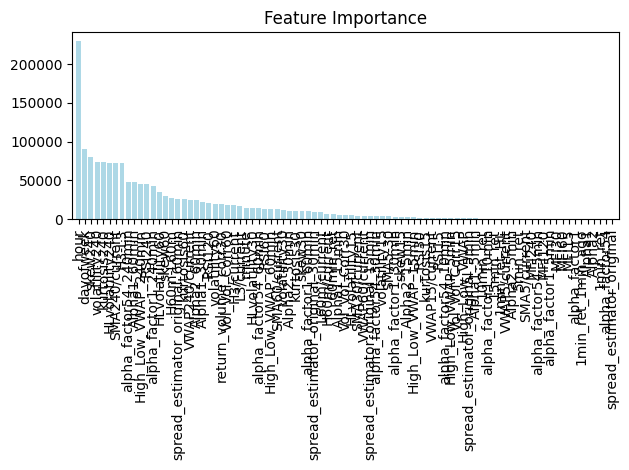

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#特徴量の重要度
feature = gbm.feature_importance(importance_type='gain')

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)

#特徴量の名前
label = X_train.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation = 90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()